In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import nltk, spacy, string, re
from nltk.stem.porter import PorterStemmer

from imblearn.over_sampling import SMOTE


from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session

from collections import Counter

In [4]:
nltk.download('punkt')
string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
news = fetch_20newsgroups(subset='all')

In [6]:
def fetch_data(data, slope=1000):

    remainder = slope
    data_l = []
    batches = len(data.data) // slope + 1

    for i in range(batches):

        x = i * slope

        if i == batches - 1:
            remainder = len(data.data) % slope
        
        datas = np.c_[data.data[x:x + remainder], data.target[x:x + remainder]]
        data_l.append(pd.DataFrame(datas, columns=['text', 'target']))
    
    return pd.concat(data_l)

In [7]:
df = fetch_data(news)

In [8]:
df['target'] = df.loc[:, 'target'].apply(int)
df.head()

,text,target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


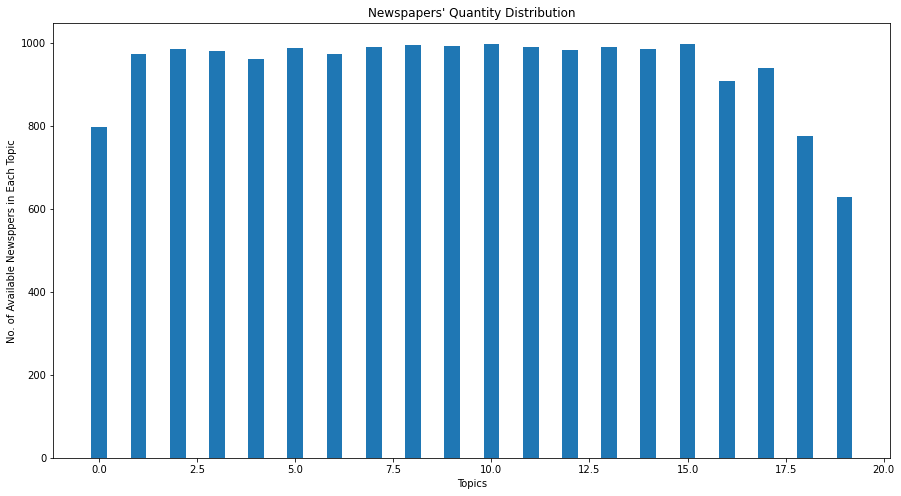

In [9]:
counter = Counter(df['target'].tolist())

classes = list(counter.keys())
values = list(counter.values())

fig = plt.figure(figsize = (15, 8))

plt.bar(classes, values, width = 0.4)

plt.xlabel("Topics")
plt.ylabel("No. of Available Newsppers in Each Topic")
plt.title("Newspapers' Quantity Distribution")
plt.show()

In [10]:
def preprocess(df, col_name='text'):
    
    column = df[col_name].tolist()
    puncs = string.punctuation
    sp = spacy.load('en_core_web_sm')
    stp_wrds = sp.Defaults.stop_words
    txt = ''
    stemmer = PorterStemmer()
    result = []

    for each_txt in column:
        txt = each_txt.lower()
        txt = re.sub(r'\n', ' ', txt)
        txt = re.sub(r'\s{2,}', ' ', txt)
        mytable = txt.maketrans('', '', puncs)
        txt = txt.translate(mytable)
        tokens = txt.split(' ')
        tokens = [word for word in tokens if not word in stp_wrds]
        tokens = [word for word in tokens if  word.isalpha()]
        tokens = [stemmer.stem(each) for each in tokens]
        result.append(' '.join(tokens))

    df['Cleaned_' + col_name] = result
    return df

In [11]:
df = preprocess(df, 'text')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18846 entries, 0 to 845
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          18846 non-null  object
 1   target        18846 non-null  int64 
 2   Cleaned_text  18846 non-null  object
dtypes: int64(1), object(2)
memory usage: 588.9+ KB


In [13]:
X, y = df.Cleaned_text, df.target
sm = SMOTE()

tfidf = TfidfVectorizer()
tfidf.fit(X, y)

X_vec = tfidf.transform(X)
X_sm, y_sm = sm.fit_resample(X_vec, y)

x_tr, x_ts, y_tr, y_ts = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm)

In [14]:
def fit_model(X, x_train, x_test, y_train, y_test, report=True, draw_heatmap=True):

    model = X
    model.fit(x_train, y_train)

    pred = model.predict(x_test)
    
    if report:
        print(classification_report(list(y_test), pred))
        
    if draw_heatmap:
        print()
        matrix = confusion_matrix(list(y_test), pred)

        sns.set()
        plt.figure(figsize = (15, 15))
    
        sns.heatmap(matrix.T,
                    square = True,
                    annot = True,
                    fmt = 'd',
                    cbar = False,
                    linewidths = .9,
                    xticklabels = np.unique(y_train).tolist(),
                    yticklabels = np.unique(y_train).tolist())

        plt.xlabel('Truth')
        plt.ylabel('Predicted')

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       200
           1       0.83      0.85      0.84       199
           2       0.86      0.87      0.87       199
           3       0.74      0.79      0.76       200
           4       0.87      0.88      0.88       200
           5       0.89      0.89      0.89       200
           6       0.92      0.71      0.80       199
           7       0.94      0.91      0.92       200
           8       0.96      0.95      0.96       200
           9       0.98      0.96      0.97       200
          10       0.97      0.98      0.97       200
          11       0.92      0.97      0.94       200
          12       0.84      0.85      0.85       200
          13       0.97      0.93      0.95       200
          14       0.94      0.96      0.95       200
          15       0.89      0.93      0.91       200
          16       0.79      0.97      0.87       200
          17       0.95    

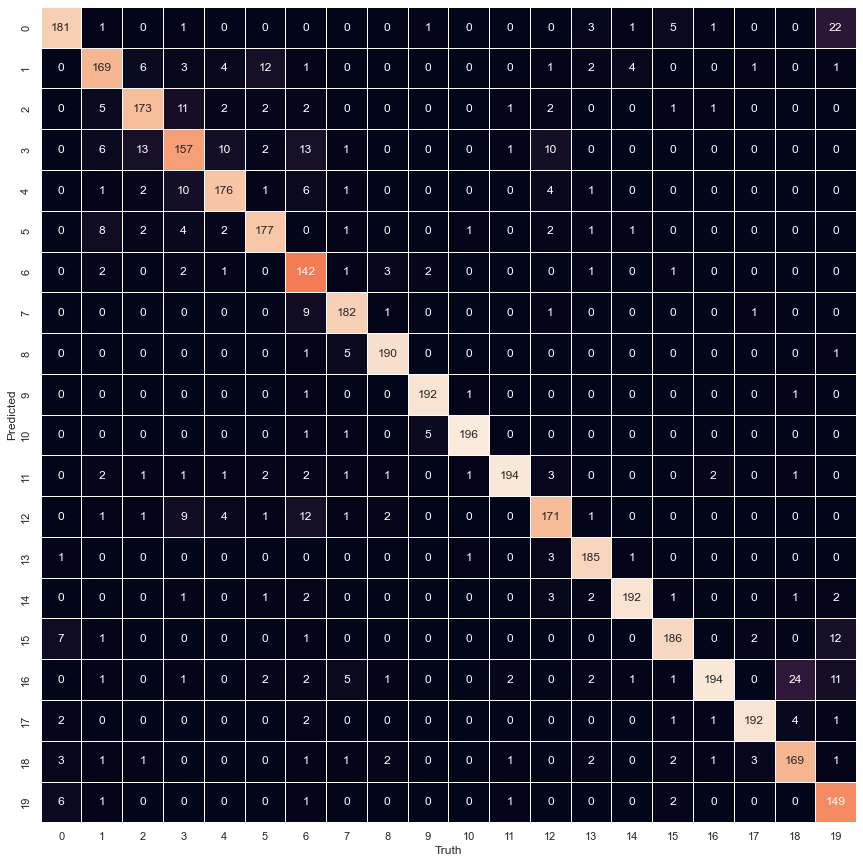

In [15]:
fit_model(MultinomialNB(), x_tr, x_ts, y_tr, y_ts)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       200
           1       0.73      0.84      0.78       199
           2       0.84      0.82      0.83       199
           3       0.74      0.73      0.74       200
           4       0.89      0.84      0.87       200
           5       0.85      0.91      0.88       200
           6       0.86      0.82      0.84       199
           7       0.92      0.93      0.92       200
           8       0.97      0.96      0.97       200
           9       0.98      0.96      0.97       200
          10       0.98      0.97      0.98       200
          11       0.98      0.91      0.94       200
          12       0.81      0.89      0.85       200
          13       0.94      0.95      0.95       200
          14       0.95      0.96      0.96       200
          15       0.92      0.93      0.92       200
          16       0.90      0.95      0.93       200
          17       0.98    

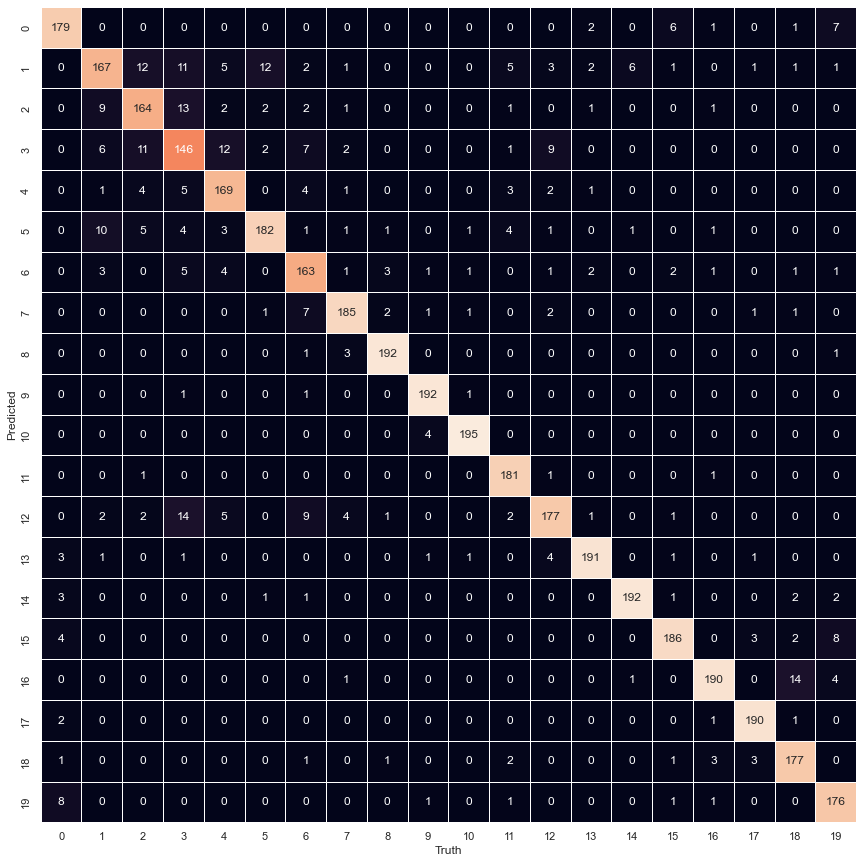

In [16]:
fit_model(LogisticRegression(solver='newton-cg', class_weight='balanced'), x_tr, x_ts, y_tr, y_ts)

In [17]:
X, y = df.Cleaned_text, df.target

text_train, text_test, target_train, target_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [18]:
MAX_WORDS = 10000
MAX_SEQUENCES = 1000


keras_tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(text_train)

word_index = keras_tokenizer.word_index
vocab_size = len(word_index)
train_sequences = keras_tokenizer.texts_to_sequences(text_train)
train_sequences_padded = pad_sequences(train_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

test_sequences = keras_tokenizer.texts_to_sequences(text_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

In [19]:
# x_tr_sm, y_tr_sm = sm.fit_resample(train_sequences_padded, target_train)
# x_ts_sm, y_ts_sm = sm.fit_resample(test_sequences_padded, target_test)

In [42]:
def make_NN(x_train, x_test, y_train, y_test, vocab_size, embedding_dim=32, epochs=50):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCES),
    # tf.keras.layers.Bidirectional(LSTM(128)),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
    ])
    
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weights = {i: w for i, w in enumerate(weights)}
    
    date = datetime.today().strftime('%Y-%m-%d')
    
    model_path=f'models/model {date}/best_model.h5'
    model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, mode='min')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    print()

    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose='auto',
                    validation_split=0.25,
                    batch_size=64,
                    class_weight=weights,
                    callbacks=[model_checkpoint])
    
    predicted_texts = model.predict(x_test)
    print()

    loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    clear_session()

    return history, predicted_texts

In [43]:
hist, pred = make_NN(train_sequences_padded, test_sequences_padded, target_train, target_test, vocab_size=vocab_size)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1000, 32)          2786528   
                                                                 
 global_average_pooling1d_8   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 20)                660       
                                                                 
Total params: 2,788,244
Trainable params: 2,788,244
Non-trainable params: 0
____________________________________________

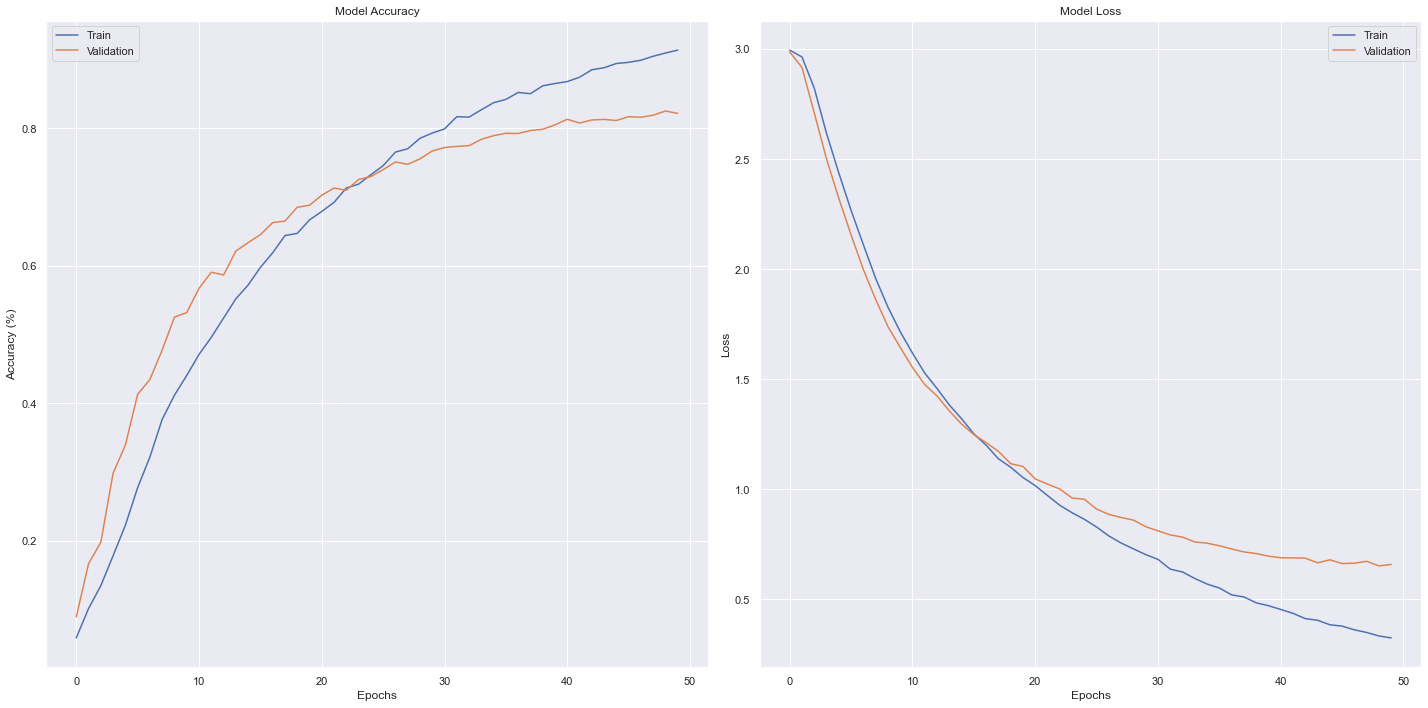

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

hist_df = pd.DataFrame(hist.history)

df_loss = hist_df[['loss', 'val_loss']].copy(deep=True)
df_acc = hist_df[['accuracy', 'val_accuracy']].copy(deep=True)

df_acc.rename(columns={'accuracy': 'Train', 'val_accuracy': 'Validation'}, inplace=True)
df_loss.rename(columns={'loss': 'Train', 'val_loss': 'Validation'}, inplace=True)

ax_acc = df_acc.plot(ax=ax1, figsize=(20, 10), title='Model Accuracy')
ax_loss = df_loss.plot(ax=ax2, figsize=(20, 10), title='Model Loss')

ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Accuracy (%)")

ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("Loss")

fig.tight_layout()

In [45]:
predicted = [np.argmax(pred[i]) for i in range(pred.shape[0])]
# y_test2 = [np.argmax(target_test[i]) for i in range(target_test.shape[0])]

Text(111.5, 0.5, 'Predicted')

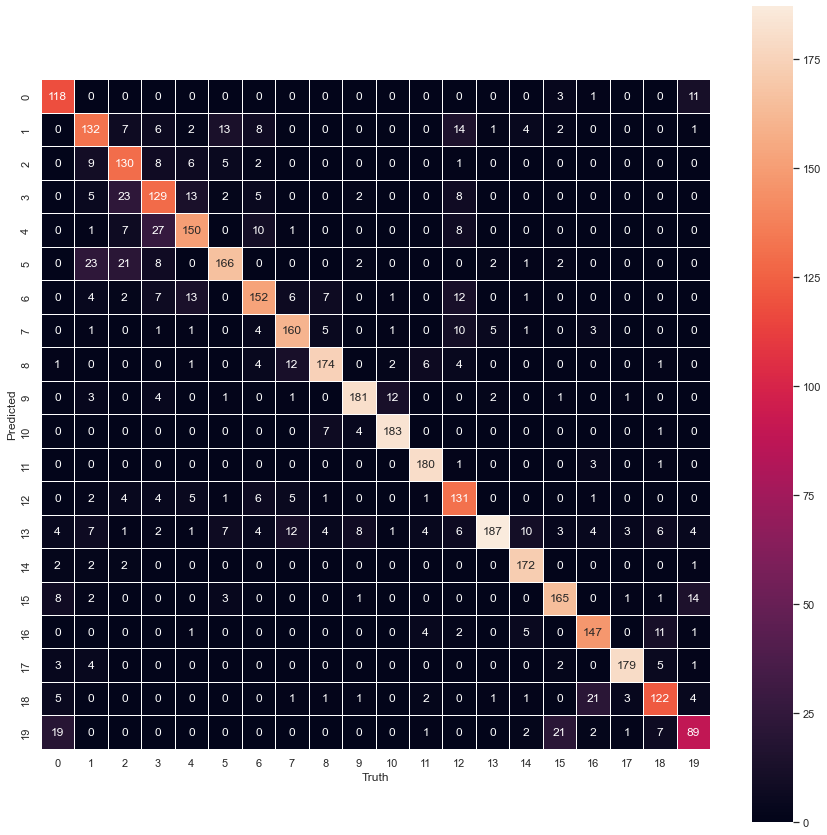

In [46]:
matrix = confusion_matrix(list(target_test), predicted)

sns.set()
plt.figure(figsize = (15, 15))

sns.heatmap(matrix.T,
            square = True,
            annot = True,
            fmt = 'd',
            cbar = True,
            linewidths = .9,
            xticklabels = np.unique(target_train).tolist(),
            yticklabels = np.unique(target_train).tolist())

plt.xlabel('Truth')
plt.ylabel('Predicted')